In [1]:
%matplotlib inline

import collections

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import neptune
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# sns.set(rc={'figure.figsize':(100, 100)})
sns.set_style('ticks', 
              rc={'axes.grid': True,
               'grid.color': '.8',
               'grid.linestyle': '-',
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False,
              })
sns.set_context("paper", font_scale=1.4)

# Get TF1 experiments results

In [3]:
project = neptune.init('michalzajac/spinup-tf1-benchmark')
tf1_experiments = project.get_experiments()
project = neptune.init('do-not-be-hasty/spinup-bis')
tf1_experiments += project.get_experiments(tag="ppo_tf1")
tf1_experiments += project.get_experiments(tag="vpg_tf1")

In [4]:
dfs = list()
for experiment in tf1_experiments:
    parameters = experiment.get_parameters()
    df = experiment.get_numeric_channels_values('AverageTestEpRet', 'TotalEnvInteracts')
    df['TF version'] = 'TF v1'
    df['algo'] = parameters['algo'].upper()
    df['seed'] = parameters['seed']
    df['task'] = parameters['env_name']
    dfs.append(df)
tf1_df = pd.concat(dfs, ignore_index=True)

In [5]:
tf1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262500 entries, 0 to 262499
Data columns (total 7 columns):
x                    262500 non-null float64
AverageTestEpRet     262500 non-null float64
TotalEnvInteracts    262500 non-null float64
TF version           262500 non-null object
algo                 262500 non-null object
seed                 262500 non-null float64
task                 262500 non-null object
dtypes: float64(4), object(3)
memory usage: 14.0+ MB


In [6]:
tf1_df.head()

,x,AverageTestEpRet,TotalEnvInteracts,TF version,algo,seed,task
0,4000.0,-64.075539,4000.0,TF v1,DDPG,2.0,Ant-v2
1,8000.0,-385.774109,8000.0,TF v1,DDPG,2.0,Ant-v2
2,12000.0,-1636.521851,12000.0,TF v1,DDPG,2.0,Ant-v2
3,16000.0,-138.021637,16000.0,TF v1,DDPG,2.0,Ant-v2
4,20000.0,-329.142334,20000.0,TF v1,DDPG,2.0,Ant-v2


# Get TF2 experiments results

In [7]:
project = neptune.init('piojanu/bayesian-exploration')
tf2_experiments = (project.get_experiments(tag="inspiring_hypatia") +
                   project.get_experiments(tag="zealous_dijkstra"))
project = neptune.init('mateusz/bayesian-exploration')
tf2_experiments += project.get_experiments(tag="peaceful_darwin")
project = neptune.init('do-not-be-hasty/spinup-bis')
tf2_experiments += project.get_experiments(tag="ppo_tf2")
tf2_experiments += project.get_experiments(tag="vpg_tf2")

In [8]:
dfs = list()
for experiment in tf2_experiments:
    parameters = experiment.get_parameters()
    df = experiment.get_numeric_channels_values('AverageTestEpRet', 'TotalEnvInteracts')
    df['TF version'] = 'TF v2'
    df['algo'] = parameters['agent'].rsplit('.', 1)[1].upper()
    df['seed'] = parameters['seed']
    df['task'] = parameters['task']
    dfs.append(df)
tf2_df = pd.concat(dfs, ignore_index=True)

In [9]:
tf2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202482 entries, 0 to 202481
Data columns (total 7 columns):
x                    202482 non-null float64
AverageTestEpRet     202482 non-null float64
TotalEnvInteracts    202482 non-null float64
TF version           202482 non-null object
algo                 202482 non-null object
seed                 202482 non-null float64
task                 202482 non-null object
dtypes: float64(4), object(3)
memory usage: 10.8+ MB


In [10]:
tf2_df.head()

,x,AverageTestEpRet,TotalEnvInteracts,TF version,algo,seed,task
0,3999.0,47.682289,3999.0,TF v2,DDPG,42.0,Hopper-v2
1,7999.0,180.113415,7999.0,TF v2,DDPG,42.0,Hopper-v2
2,11999.0,234.054704,11999.0,TF v2,DDPG,42.0,Hopper-v2
3,15999.0,274.743439,15999.0,TF v2,DDPG,42.0,Hopper-v2
4,19999.0,332.100597,19999.0,TF v2,DDPG,42.0,Hopper-v2


# Plot

In [11]:
data = pd.concat([tf1_df, tf2_df], ignore_index=True)

## Preprocess data

In [12]:
# Cut after 3M timesteps.
data = data[data['TotalEnvInteracts'] <= 3000000]

# Apply Exponentially Weighted Moving Average to the performance.
data['AverageTestEpRet'] = data.groupby(['TF version', 'algo', 'seed', 'task'])['AverageTestEpRet'].apply(
            lambda s: s.ewm(span=10).mean())


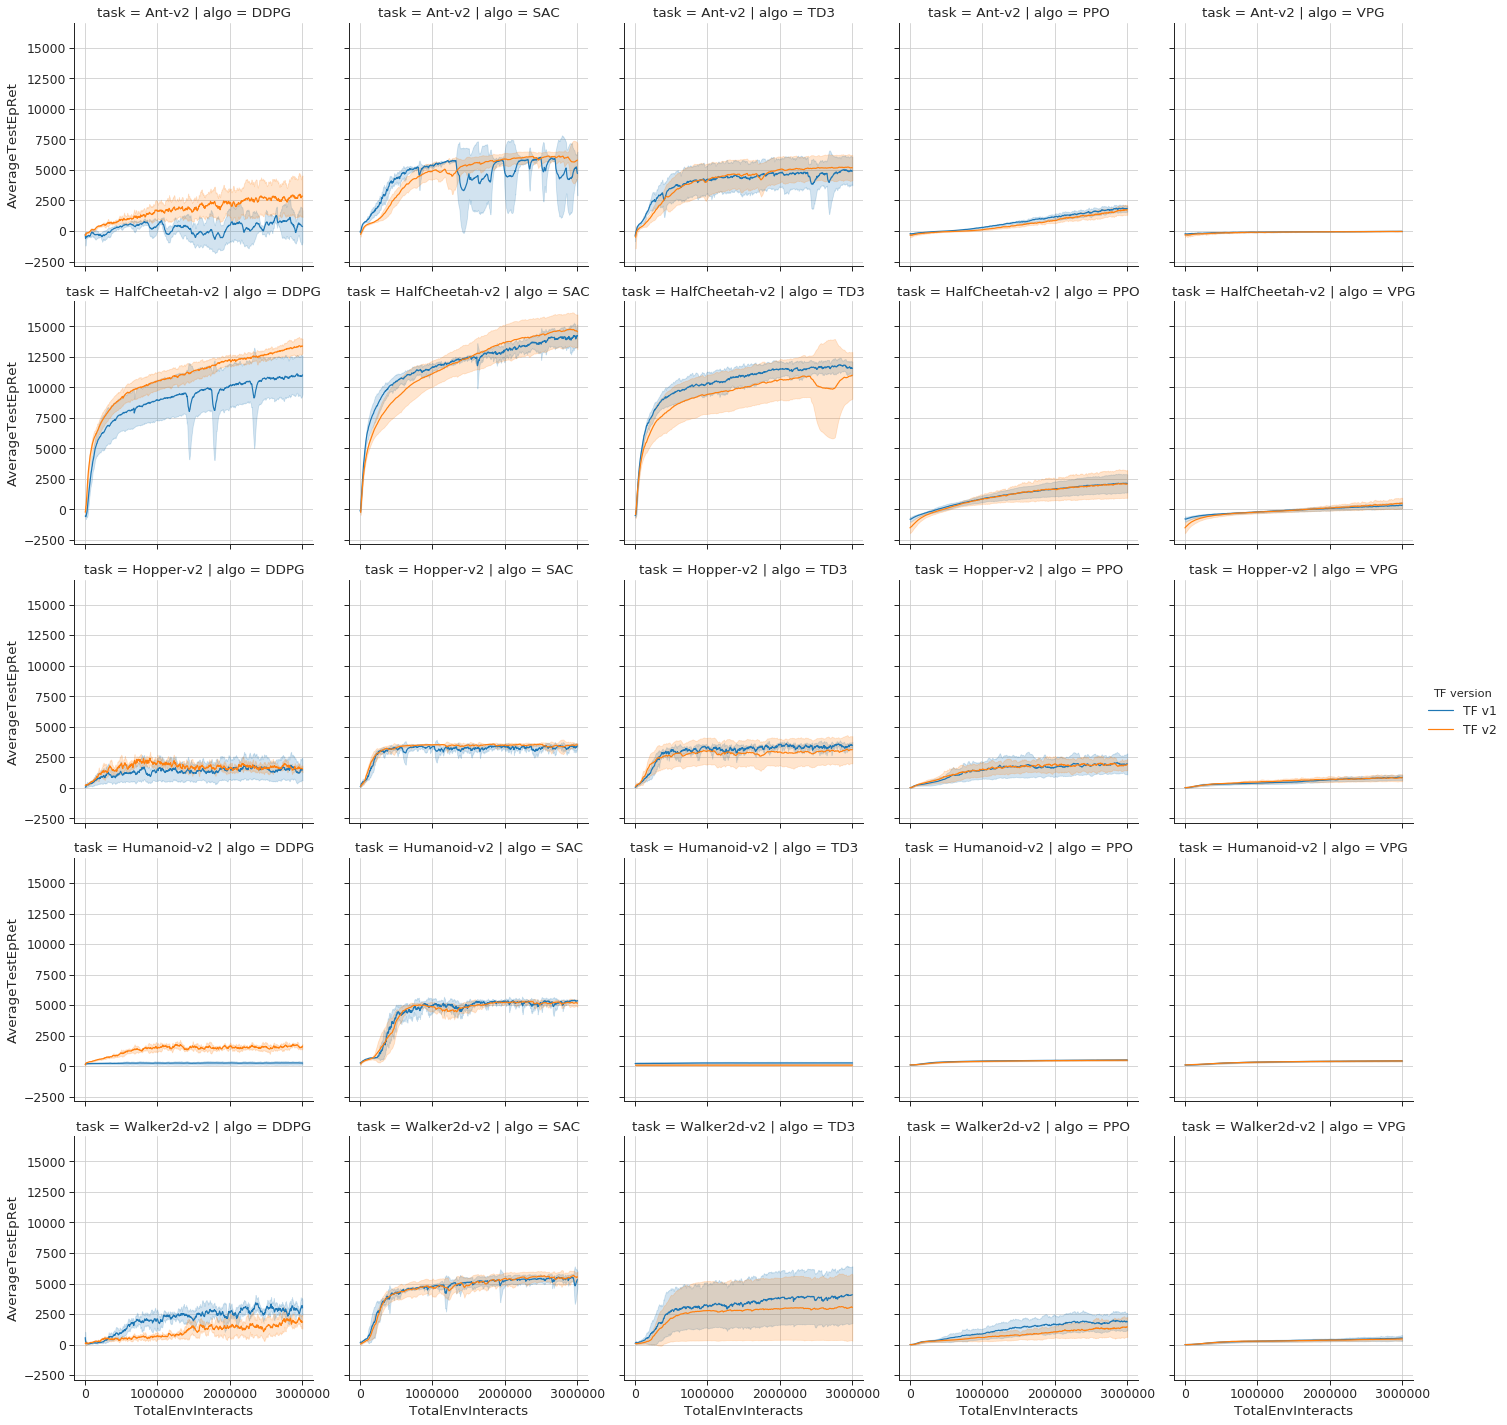

In [13]:
g = sns.FacetGrid(data, row='task', col='algo', hue='TF version', height=4)
g.map(sns.lineplot, 'TotalEnvInteracts', 'AverageTestEpRet', ci='sd')
g.add_legend()

In [14]:
g.savefig("imgs/compare_performance.png")